In [1]:
from osgeo import gdal
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import datetime
import random
import xlwt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import merge
import keras

In [2]:
print(gdal.__version__)

3.2.3


In [3]:
print(tf.__version__)

2.4.0


In [4]:
print(keras.__version__)

2.4.3


#### Asign GPU memory 

In [5]:
'''
GPU == 1080ti
CUDA version == 11.3.55
cudnn-11.3-windows-x64-v8.2.0.53
'''

'\nGPU == 1080ti\nCUDA version == 11.3.55\ncudnn-11.3-windows-x64-v8.2.0.53\n'

In [6]:
'''
Necessary, other wise will have error in train_generator() (index out of range)
'''
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #The first GPU
config=tf.compat.v1.ConfigProto()
# The program can only occupy up to 90% of the specified GPU memory
config.gpu_options.per_process_gpu_memory_fraction = 0.9 
#The program allocates memory on demand
config.gpu_options.allow_growth = True 
sess=tf.compat.v1.Session(config=config)

#### Test GPU

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print('GPU', tf.test.is_gpu_available())

a = tf.constant(2.0)
b = tf.constant(4.0)
print(a + b)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU True
tf.Tensor(6.0, shape=(), dtype=float32)


#### Define def

In [8]:
def normalize(img):
    #min of each channel
    minlist = [414, 457, 408, 325, 321, 352, 273, 262, 246, 258, 151, 124, 114, 119, 108, 135, 107, 99, 117, 93, 121, 127, 125, 138, 109, 107, 97, 100, 101, 68, 62, 57]
    #max - min (channel)
    diflist = [599, 566, 615, 698, 702, 671, 750, 761, 777, 765, 872, 899, 909, 904, 915, 888, 876, 848, 906, 703, 900, 896, 872, 762, 656, 682, 672, 739, 635, 510, 445, 198]
    img = img.astype(np.float32)
    
    #make sure all data in 0~1
    #(i-min)/(max-min)
    for i in range(32):
        img[i][np.where(img[i]==0)]=minlist[i]
        img[i] = (img[i]-minlist[i])/diflist[i]
        img[i] = img[i]*255
    return img

In [9]:
def load_img(path):
    dataset = gdal.Open(path)
    im_width = dataset.RasterXSize
    im_height = dataset.RasterYSize
    im_data = dataset.ReadAsArray(0,0,im_width,im_height)
    
    im_data = im_data.transpose((1,2,0))
    return im_data
def dataPreprocess(img, label, classNum, colorDict_GRAY):
    #  normalize
    img = img / 255.0
    for i in range(colorDict_GRAY.shape[0]):
        label[label == colorDict_GRAY[i][0]] = i
    #  Extend the data thickness to the classNum (including background) layer
    new_label = np.zeros(label.shape + (classNum,))
    #  Turn each type of flat label into a separate layer
    for i in range(classNum):
        new_label[label == i,i] = 1                                          
    label = new_label
    return (img, label)


In [10]:
#  read .tif image
def readTif(fileName):
    dataset = gdal.Open(fileName)
    im_width = dataset.RasterXSize
    im_height = dataset.RasterYSize
    if dataset == None:
        print(fileName + "file can not open")
    return dataset
#  save .tif image
def writeTiff(im_data, im_geotrans, im_proj, path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
        im_bands, im_height, im_width = im_data.shape
    #创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans) #Write affine transformation parameters
        dataset.SetProjection(im_proj) #Write projection
    for i in range(im_bands):
        dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    del dataset

In [11]:
def color_dict(labelFolder, classNum):
    colorDict = []
    #  Get the file name in the folder
    ImageNameList = os.listdir(labelFolder)
    for i in range(len(ImageNameList)):
        ImagePath = labelFolder + "/" + ImageNameList[i]
        img = cv2.imread(ImagePath).astype(np.uint32)
        img[img==255]=0
        #  If it is grayscale, convert to RGB
        if(len(img.shape) == 2):
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.uint32)
        #  In order to extract the unique value, convert RGB into a number
        img_new = img[:,:,0] * 1000000 + img[:,:,1] * 1000 + img[:,:,2]
        unique = np.unique(img_new)
        #  Add the unique value of the i-th pixel matrix to the colorDict
        for j in range(unique.shape[0]):
            colorDict.append(unique[j])
        #  Take the unique value for the unique value in the current i pixel matrix
        colorDict = sorted(set(colorDict))
        #  If the number of unique values is equal to the total number of classes (including background) ClassNum, 
        #stop traversing the remaining images
        if(len(colorDict) == classNum):
            break
    #  RGB dictionary storing colors, used for rendering results during prediction
    colorDict_RGB = []
    for k in range(len(colorDict)):
        #  Add zeros to the left of the result that does not reach nine digits
        color = str(colorDict[k]).rjust(9, '0')
        #  The first 3 digits are R, the middle 3 digits are G, and the last 3 digits are B
        color_RGB = [int(color[0 : 3]), int(color[3 : 6]), int(color[6 : 9])]
        colorDict_RGB.append(color_RGB)
    colorDict_RGB = np.array(colorDict_RGB)
    #  GRAY dictionary to store colors
    colorDict_GRAY = colorDict_RGB.reshape((colorDict_RGB.shape[0], 1 ,colorDict_RGB.shape[1])).astype(np.uint8)
    colorDict_GRAY = cv2.cvtColor(colorDict_GRAY, cv2.COLOR_BGR2GRAY)
    return colorDict_RGB, colorDict_GRAY

In [12]:
def trainGenerator(batch_size, train_image_path, train_label_path, classNum, colorDict_GRAY, resize_shape = None):
    imageList = os.listdir(train_image_path)
    labelList = os.listdir(train_label_path)

    img = load_img(train_image_path + "/" + imageList[0])
    #  generate data
    while(True):
        img_generator = np.zeros((batch_size, img.shape[0], img.shape[1], img.shape[2]))
        label_generator = np.zeros((batch_size, img.shape[0], img.shape[1]), np.uint8)
        if(resize_shape != None):
            img_generator = np.zeros((batch_size, resize_shape[0], resize_shape[1], resize_shape[2]))
            label_generator = np.zeros((batch_size, resize_shape[0], resize_shape[1]), np.uint8)
        #  randomly select a starting point for batch
        rand = random.randint(0, len(imageList) - batch_size)
        for j in range(batch_size):           
            img = load_img(train_image_path + "/" + imageList[rand + j])
            #normalize
            img = img.swapaxes(1, 2)
            img = img.swapaxes(1, 0)
            
            img = normalize(img)
            
            img = img.swapaxes(1, 0)
            img = img.swapaxes(1, 2)

            #  change shape
            if(resize_shape != None):
                img = np.resize(img, (resize_shape[0], resize_shape[1], resize_shape[2]))
            
            img_generator[j] = img
            
            label = cv2.imread(train_label_path + "/" + labelList[rand + j])
            label[label==255]=0
            
            #  color to grayscale
            if(len(label.shape) == 3):
                label = cv2.cvtColor(label, cv2.COLOR_RGB2GRAY)
            if(resize_shape != None):
                label = cv2.resize(label, (resize_shape[0], resize_shape[1]))
            label_generator[j] = label
        img_generator, label_generator = dataPreprocess(img_generator, label_generator, classNum, colorDict_GRAY)
        yield (img_generator,label_generator)

#### Define unet

In [13]:
def unet(pretrained_weights = None, input_size = (256, 256, 32), classNum = 5, learning_rate = 1e-4):
    inputs = Input(input_size)
    #  2D-Dimensional Convolution Layer
    conv1 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs))
    conv1 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1))
    #  Max Pooling to the data
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1))
    conv2 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2))
    conv3 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3))
    conv4 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4))
    #  Dropout regularization and avoid overfitting
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
 
    conv5 = BatchNormalization()(Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4))
    conv5 = BatchNormalization()(Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5))
    drop5 = Dropout(0.5)(conv5)
    #  transposed convolution
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    
    try:
        merge6 = concatenate([drop4,up6],axis = 3)
    except:
        merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6))
    conv6 = BatchNormalization()(Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6))
 
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    try:
        merge7 = concatenate([conv3,up7],axis = 3)
    except:
        merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7))
    conv7 = BatchNormalization()(Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7))
 
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    try:
        merge8 = concatenate([conv2,up8],axis = 3)
    except:
        merge8 = merge([conv2,up8],mode = 'concat', concat_axis = 3)
    conv8 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8))
    conv8 = BatchNormalization()(Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8))
 
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    try:
        merge9 = concatenate([conv1,up9],axis = 3)
    except:
        merge9 = merge([conv1,up9],mode = 'concat', concat_axis = 3)
    conv9 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9))
    conv9 = BatchNormalization()(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9))
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(classNum, 1, activation = 'softmax')(conv9)
 
    model = Model(inputs = inputs, outputs = conv10)
 
    #  Used to configure the training model (optimizer, objective function, model evaluation criteria)
    model.compile(optimizer = Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
 
    return model

#### All the parameter

In [14]:
'''
PATH parameter
'''
#  training image PATH
train_image_path = "./comp/train/imagescut"
#  training label PATH
train_label_path = "./comp/train/labelscut"
#  validation image PATH
validation_image_path = "./comp/train/it"
#  validation label PATH
validation_label_path = "./comp/train/lt"

'''
Model parameter
'''
#  batch size
batch_size = 2
#  number of label
classNum = 5
#  shape of input images (2**n)
input_size = (256, 256, 32)
#  epochs
epochs = 10
#  learning rate
learning_rate = 1e-2
#  pretrained model PATH
# premodel_path = "./Model/unet_model.hdf5"
premodel_path = None
#  save model PATH
model_path = "./Model/unet_model.hdf5"

#  number of training set
train_num = len(os.listdir(train_image_path))
#  number of validation set
validation_num = len(os.listdir(validation_image_path))
#  how much batch size in each epoch for training set
steps_per_epoch = train_num / batch_size
#  how much batch size in each epoch for validation set
validation_steps = validation_num / batch_size
#  color directory for label
colorDict_RGB, colorDict_GRAY = color_dict(train_label_path, classNum)

#### Model training

In [15]:
#  get a generator to generate training data at the rate of batch_size
train_Generator = trainGenerator(batch_size,
                                 train_image_path, 
                                 train_label_path,
                                 classNum ,
                                 colorDict_GRAY,
                                 input_size)

#  get a generator to generate validation data at the rate of batch_size
validation_data = trainGenerator(batch_size,
                                 validation_image_path,
                                 validation_label_path,
                                 classNum,
                                 colorDict_GRAY,
                                 input_size)
#  define the model
model = unet(pretrained_weights = premodel_path, 
             input_size = input_size, 
             classNum = classNum, 
             learning_rate = learning_rate)
#  print model structure
model.summary()
#  Callback
model_checkpoint = ModelCheckpoint(model_path,
                                   monitor = 'loss',
                                   verbose = 1,
                                   save_best_only = True)

#  get time
start_time = datetime.datetime.now()

#  model training
history = model.fit(train_Generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    callbacks = [model_checkpoint],
                    validation_data = validation_data,
                    validation_steps = validation_steps)

#  total training time
end_time = datetime.datetime.now()
log_time = "Total training time: " + str((end_time - start_time).seconds / 60) + "m"
print(log_time)
with open('TrainTime.txt','w') as f:
    f.write(log_time)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 32 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 18496       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

576/576 [==============================] - 112s 183ms/step - loss: 1.2776 - accuracy: 0.5359 - val_loss: 0.7869 - val_accuracy: 0.8046

Epoch 00001: loss improved from inf to 1.13724, saving model to ./Model\unet_model.hdf5
Epoch 2/10
576/576 [==============================] - 126s 219ms/step - loss: 0.9270 - accuracy: 0.5955 - val_loss: 0.7291 - val_accuracy: 0.6827

Epoch 00002: loss improved from 1.13724 to 0.87550, saving model to ./Model\unet_model.hdf5
Epoch 3/10
576/576 [==============================] - 164s 285ms/step - loss: 0.7231 - accuracy: 0.6963 - val_loss: 0.7795 - val_accuracy: 0.5917

Epoch 00003: loss improved from 0.87550 to 0.69117, saving model to ./Model\unet_model.hdf5
Epoch 4/10
576/576 [==============================] - 205s 356ms/step - loss: 0.6625 - accuracy: 0.7376 - val_loss: 470458.3750 - val_accuracy: 0.8261

Epoch 00004: loss improved from 0.69117 to 0.64793, saving model to ./Model\unet_model.hdf5
Epoch 5/10
576/576 [==============================] - 

#### Accuracy and loss

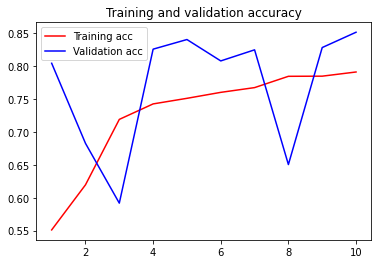

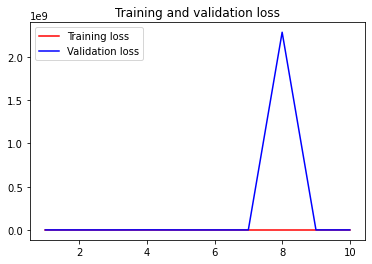

In [16]:
#  plot loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
book = xlwt.Workbook(encoding='utf-8', style_compression=0)
sheet = book.add_sheet('test', cell_overwrite_ok=True)
for i in range(len(acc)):
    sheet.write(i, 0, acc[i])
    sheet.write(i, 1, val_acc[i])
    sheet.write(i, 2, loss[i])
    sheet.write(i, 3, val_loss[i])
book.save(r'AccAndLoss.xls')
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("accuracy.png",dpi = 300)
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("loss.png", dpi = 300)
plt.show() 
